In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [2]:
import matplotlib.pyplot as plt
from cmplotter import plot_confusion_matrix
%matplotlib inline
import numpy as np
#Set some numpy print options for displaying numpy arrays to fit maximum width of cell
np.set_printoptions(precision=8, edgeitems=30, linewidth=1000,formatter=dict(float=lambda x: "%.8g" % x))

import pandas as pd
from xgboost import XGBClassifier,plot_tree
from sklearn import datasets
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.preprocessing import LabelEncoder,label_binarize

In [3]:
#load Dataset
data = pd.read_csv('data/2016_EGLL_Testdata_cleaned.csv', parse_dates = ['Landing_Time'], infer_datetime_format = True)
data.head()

,Landing_Time,hourofday,aircraft_registration,wind_direction_degrees,Wind_Speed_kt,Wind_And_Gust_kt,Landing_RVR_or_Vis_m,temperature_c,dew_point_c,relative_humidity,pressure_altimiter_in,RunwayTrueTrack,Landing_Visibilty_Class_RVR,present_weather_codes,Landing_RWY
0,2016-01-01 04:34:38,4,GXLEJ,NaN,1.0,1.0,6000.0,2.0,1.0,93.08,30.21,89.713523,VMC,NaN,RW09R
1,2016-01-01 04:38:22,4,GSTBH,NaN,1.0,1.0,6000.0,2.0,1.0,93.08,30.21,89.713523,VMC,NaN,RW09R
2,2016-01-01 04:40:38,4,GCIVH,110.0,1.0,1.0,6000.0,2.0,1.0,93.08,30.21,89.713523,VMC,NaN,RW09R
3,2016-01-01 04:42:36,4,GVYUM,110.0,1.0,1.0,6000.0,2.0,1.0,93.08,30.21,89.713523,VMC,NaN,RW09R
4,2016-01-01 04:44:43,4,GBYGB,110.0,1.0,1.0,6000.0,2.0,1.0,93.08,30.21,89.713523,VMC,NaN,RW09R


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220940 entries, 0 to 220939
Data columns (total 15 columns):
Landing_Time                   220940 non-null datetime64[ns]
hourofday                      220940 non-null int64
aircraft_registration          220799 non-null object
wind_direction_degrees         203226 non-null float64
Wind_Speed_kt                  220940 non-null float64
Wind_And_Gust_kt               220940 non-null float64
Landing_RVR_or_Vis_m           220940 non-null float64
temperature_c                  220940 non-null float64
dew_point_c                    220940 non-null float64
relative_humidity              220940 non-null float64
pressure_altimiter_in          220940 non-null float64
RunwayTrueTrack                220940 non-null float64
Landing_Visibilty_Class_RVR    220940 non-null object
present_weather_codes          33015 non-null object
Landing_RWY                    220940 non-null object
dtypes: datetime64[ns](1), float64(9), int64(1), object(4)
memor

In [5]:
# One-Hot Encoding Categorical Variables pertaining to Visibility and Weather conditions which are interesting features
data = pd.get_dummies(data, columns=['Landing_Visibilty_Class_RVR', 'present_weather_codes'])
# Dropping Categorical variables which are not going to be used by the GBM model
data.drop(columns=['Landing_Time', 'aircraft_registration'],inplace = True)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220940 entries, 0 to 220939
Data columns (total 65 columns):
hourofday                                   220940 non-null int64
wind_direction_degrees                      203226 non-null float64
Wind_Speed_kt                               220940 non-null float64
Wind_And_Gust_kt                            220940 non-null float64
Landing_RVR_or_Vis_m                        220940 non-null float64
temperature_c                               220940 non-null float64
dew_point_c                                 220940 non-null float64
relative_humidity                           220940 non-null float64
pressure_altimiter_in                       220940 non-null float64
RunwayTrueTrack                             220940 non-null float64
Landing_RWY                                 220940 non-null object
Landing_Visibilty_Class_RVR_CAT1            220940 non-null uint8
Landing_Visibilty_Class_RVR_CAT2            220940 non-null uint8
Landing_Visi

In [7]:
input_features = data.copy()
X_data = input_features.drop('Landing_RWY', axis=1)
y = data.Landing_RWY.values

In [8]:
X_data.head()

,hourofday,wind_direction_degrees,Wind_Speed_kt,Wind_And_Gust_kt,Landing_RVR_or_Vis_m,temperature_c,dew_point_c,relative_humidity,pressure_altimiter_in,RunwayTrueTrack,...,present_weather_codes_SHRA,present_weather_codes_SHRA HZ,present_weather_codes_SHRA VCTS,present_weather_codes_TS,present_weather_codes_TSRA,present_weather_codes_VCFG,present_weather_codes_VCSH,present_weather_codes_VCTS,present_weather_codes_VCTS -SHRA,present_weather_codes_VCTS VCSH
0,4,NaN,1.0,1.0,6000.0,2.0,1.0,93.08,30.21,89.713523,...,0,0,0,0,0,0,0,0,0,0
1,4,NaN,1.0,1.0,6000.0,2.0,1.0,93.08,30.21,89.713523,...,0,0,0,0,0,0,0,0,0,0
2,4,110.0,1.0,1.0,6000.0,2.0,1.0,93.08,30.21,89.713523,...,0,0,0,0,0,0,0,0,0,0
3,4,110.0,1.0,1.0,6000.0,2.0,1.0,93.08,30.21,89.713523,...,0,0,0,0,0,0,0,0,0,0
4,4,110.0,1.0,1.0,6000.0,2.0,1.0,93.08,30.21,89.713523,...,0,0,0,0,0,0,0,0,0,0


In [9]:
# Number of unique values Ytrn
n_classes = len(np.unique(y))
print('No. of Classes in the output:',n_classes,'and the classes are:',np.unique(y))

No. of Classes in the output: 4 and the classes are: ['RW09L' 'RW09R' 'RW27L' 'RW27R']


In [10]:
## One Hot Encode categorical variable output converting the class labels to integers
encoder = LabelEncoder()
encoded_y = encoder.fit_transform(y)
print('Encoded-Y:',encoded_y)

Encoded-Y: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 0 1 0 1 0 1 0 ... 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [11]:
## Convert class labels to binary representation for each of the four classes such as [0 1 0 0], [1 0 0 0], [0 0 1 0] and [0 0 0 1]
# y_bin_enc = label_binarize(y, classes=['RW09L','RW09R','RW27L','RW27R'])
# print('Output-Y:',y_bin_enc)

In [12]:
#Split the dataset into train and Test
seed = 42
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X_data, y, test_size=test_size, random_state=seed)

In [13]:
# Sanity Check
print("Train dataset contains {0} rows and {1} columns".format(X_train.shape[0], X_train.shape[1]))
print("Test dataset contains {0} rows and {1} columns".format(X_test.shape[0], X_test.shape[1]))

Train dataset contains 154658 rows and 64 columns
Test dataset contains 66282 rows and 64 columns


In [14]:
print("Train possible labels: ")
print(np.unique(y_train))

print("\nTest possible labels: ")
print(np.unique(y_test))

Train possible labels: 
['RW09L' 'RW09R' 'RW27L' 'RW27R']

Test possible labels: 
['RW09L' 'RW09R' 'RW27L' 'RW27R']


In [15]:
def correct_predictions_counter(y_test,y_pred):
    '''Takes in the predictions of a model output and returns the no. of correct predictions.
    Arguments: y_test, y_pred'''
    correct = 0
    for i in range(len(y_pred)):
        if (y_test[i] == y_pred[i]):
            correct += 1
    return correct

## Training Classifier

### Using Randomized Search for HyperParameter Tuning

In [16]:
# Parameters for the XGB Classifier used as estimator in the RandomizedSearch
params_xgbclassifier = {
    'objective': 'multi:softmax',    
    'silent': 1,
    'num_class': n_classes    
}

# Parameters for the Randomized Search
params_rsearch_short = { 
    'max_depth':[4,8,16],
    'n_estimators':[500,1000,2000],
    'learning_rate': [0.0075,0.01,0.02] ,
    'subsample': [0.5,0.75,0.9],
    'colsample_bytree': [0.4, 0.8, 1.0],
    'min_child_weight': [3.0, 7.0, 10.0],
    'gamma': [0.25, 0.5, 1.0],
}

fit_params = {'eval_metric': 'mlogloss',
              'early_stopping_rounds': 10,
              'verbose': False,
              'eval_set': [(X_test, y_test)]              
             }

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y, test_size=test_size, random_state=42)
rsearch = RandomizedSearchCV(estimator = XGBClassifier(**params_xgbclassifier), 
                             param_distributions = params_rsearch_short, scoring='accuracy',
                             verbose=2,n_iter= 5, cv=3,random_state = 42)

In [18]:
%%time
import time
print("Randomized search..")
search_time_start = time.time()
train_model_rs = rsearch.fit(X_train, y_train,**fit_params)
print("Randomized search time:", time.time() - search_time_start)

Randomized search..
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] subsample=0.9, n_estimators=1000, min_child_weight=10.0, max_depth=8, learning_rate=0.01, gamma=0.25, colsample_bytree=0.8 


C:\ProgramData\Anaconda3\envs\datasciencelab\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\envs\datasciencelab\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  subsample=0.9, n_estimators=1000, min_child_weight=10.0, max_depth=8, learning_rate=0.01, gamma=0.25, colsample_bytree=0.8, total=54.7min
[CV] subsample=0.9, n_estimators=1000, min_child_weight=10.0, max_depth=8, learning_rate=0.01, gamma=0.25, colsample_bytree=0.8 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 56.6min remaining:    0.0s
C:\ProgramData\Anaconda3\envs\datasciencelab\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\envs\datasciencelab\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  subsample=0.9, n_estimators=1000, min_child_weight=10.0, max_depth=8, learning_rate=0.01, gamma=0.25, colsample_bytree=0.8, total=37.8min
[CV] subsample=0.9, n_estimators=1000, min_child_weight=10.0, max_depth=8, learning_rate=0.01, gamma=0.25, colsample_bytree=0.8 


C:\ProgramData\Anaconda3\envs\datasciencelab\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\envs\datasciencelab\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  subsample=0.9, n_estimators=1000, min_child_weight=10.0, max_depth=8, learning_rate=0.01, gamma=0.25, colsample_bytree=0.8, total=27.8min
[CV] subsample=0.75, n_estimators=2000, min_child_weight=10.0, max_depth=16, learning_rate=0.0075, gamma=1.0, colsample_bytree=0.8 


C:\ProgramData\Anaconda3\envs\datasciencelab\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\envs\datasciencelab\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  subsample=0.75, n_estimators=2000, min_child_weight=10.0, max_depth=16, learning_rate=0.0075, gamma=1.0, colsample_bytree=0.8, total=104.5min
[CV] subsample=0.75, n_estimators=2000, min_child_weight=10.0, max_depth=16, learning_rate=0.0075, gamma=1.0, colsample_bytree=0.8 


C:\ProgramData\Anaconda3\envs\datasciencelab\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\envs\datasciencelab\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  subsample=0.75, n_estimators=2000, min_child_weight=10.0, max_depth=16, learning_rate=0.0075, gamma=1.0, colsample_bytree=0.8, total=104.3min
[CV] subsample=0.75, n_estimators=2000, min_child_weight=10.0, max_depth=16, learning_rate=0.0075, gamma=1.0, colsample_bytree=0.8 


C:\ProgramData\Anaconda3\envs\datasciencelab\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\envs\datasciencelab\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  subsample=0.75, n_estimators=2000, min_child_weight=10.0, max_depth=16, learning_rate=0.0075, gamma=1.0, colsample_bytree=0.8, total=104.5min
[CV] subsample=0.9, n_estimators=1000, min_child_weight=10.0, max_depth=16, learning_rate=0.01, gamma=0.5, colsample_bytree=0.8 


C:\ProgramData\Anaconda3\envs\datasciencelab\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\envs\datasciencelab\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  subsample=0.9, n_estimators=1000, min_child_weight=10.0, max_depth=16, learning_rate=0.01, gamma=0.5, colsample_bytree=0.8, total=52.7min
[CV] subsample=0.9, n_estimators=1000, min_child_weight=10.0, max_depth=16, learning_rate=0.01, gamma=0.5, colsample_bytree=0.8 


C:\ProgramData\Anaconda3\envs\datasciencelab\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\envs\datasciencelab\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  subsample=0.9, n_estimators=1000, min_child_weight=10.0, max_depth=16, learning_rate=0.01, gamma=0.5, colsample_bytree=0.8, total=52.5min
[CV] subsample=0.9, n_estimators=1000, min_child_weight=10.0, max_depth=16, learning_rate=0.01, gamma=0.5, colsample_bytree=0.8 


C:\ProgramData\Anaconda3\envs\datasciencelab\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\envs\datasciencelab\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  subsample=0.9, n_estimators=1000, min_child_weight=10.0, max_depth=16, learning_rate=0.01, gamma=0.5, colsample_bytree=0.8, total=184.6min
[CV] subsample=0.5, n_estimators=2000, min_child_weight=7.0, max_depth=8, learning_rate=0.01, gamma=0.5, colsample_bytree=0.8 


C:\ProgramData\Anaconda3\envs\datasciencelab\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\envs\datasciencelab\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  subsample=0.5, n_estimators=2000, min_child_weight=7.0, max_depth=8, learning_rate=0.01, gamma=0.5, colsample_bytree=0.8, total=66.0min
[CV] subsample=0.5, n_estimators=2000, min_child_weight=7.0, max_depth=8, learning_rate=0.01, gamma=0.5, colsample_bytree=0.8 


C:\ProgramData\Anaconda3\envs\datasciencelab\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\envs\datasciencelab\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  subsample=0.5, n_estimators=2000, min_child_weight=7.0, max_depth=8, learning_rate=0.01, gamma=0.5, colsample_bytree=0.8, total=63.8min
[CV] subsample=0.5, n_estimators=2000, min_child_weight=7.0, max_depth=8, learning_rate=0.01, gamma=0.5, colsample_bytree=0.8 


C:\ProgramData\Anaconda3\envs\datasciencelab\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\envs\datasciencelab\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  subsample=0.5, n_estimators=2000, min_child_weight=7.0, max_depth=8, learning_rate=0.01, gamma=0.5, colsample_bytree=0.8, total=63.3min
[CV] subsample=0.5, n_estimators=500, min_child_weight=10.0, max_depth=4, learning_rate=0.02, gamma=0.25, colsample_bytree=1.0 


C:\ProgramData\Anaconda3\envs\datasciencelab\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\envs\datasciencelab\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  subsample=0.5, n_estimators=500, min_child_weight=10.0, max_depth=4, learning_rate=0.02, gamma=0.25, colsample_bytree=1.0, total= 8.9min
[CV] subsample=0.5, n_estimators=500, min_child_weight=10.0, max_depth=4, learning_rate=0.02, gamma=0.25, colsample_bytree=1.0 


C:\ProgramData\Anaconda3\envs\datasciencelab\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\envs\datasciencelab\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  subsample=0.5, n_estimators=500, min_child_weight=10.0, max_depth=4, learning_rate=0.02, gamma=0.25, colsample_bytree=1.0, total= 8.9min
[CV] subsample=0.5, n_estimators=500, min_child_weight=10.0, max_depth=4, learning_rate=0.02, gamma=0.25, colsample_bytree=1.0 


C:\ProgramData\Anaconda3\envs\datasciencelab\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\envs\datasciencelab\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 984.9min finished


[CV]  subsample=0.5, n_estimators=500, min_child_weight=10.0, max_depth=4, learning_rate=0.02, gamma=0.25, colsample_bytree=1.0, total=10.6min
Randomized search time: 69883.63460755348
Wall time: 19h 24min 43s


In [19]:
%%time
pred_rs = train_model_rs.predict(X_test)

Wall time: 4min 47s


C:\ProgramData\Anaconda3\envs\datasciencelab\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


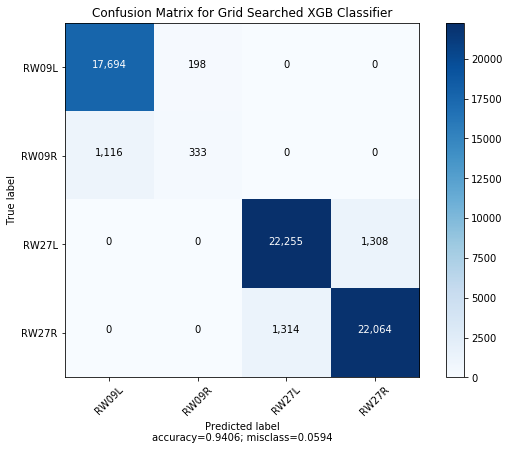

In [20]:
# Plot Confusion Matrix of classification Results
plot_confusion_matrix(cm= confusion_matrix(y_test, pred_rs), 
                      normalize    = False,
                      target_names = np.unique(y_test),
                      title        = "Confusion Matrix for RandomizedSearch XGB Classifier")

In [21]:
best_score = train_model_rs.best_score_
best_params = train_model_rs.best_params_
print("Best score: {}".format(best_score))
print("Best params: ")
for param_name in sorted(best_params.keys()):
    print('%s: %r' % (param_name, best_params[param_name]))

Best score: 0.9391172781233431
Best params: 
colsample_bytree: 0.8
gamma: 1.0
learning_rate: 0.0075
max_depth: 16
min_child_weight: 10.0
n_estimators: 2000
subsample: 0.75


In [22]:
print(rsearch)

# summarize the results of the grid search
print('\n Best Score:',rsearch.best_score_)

RandomizedSearchCV(cv=3, error_score='raise',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, num_class=4, objective='multi:softmax',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=1, subsample=1),
          fit_params=None, iid=True, n_iter=5, n_jobs=1,
          param_distributions={'max_depth': [4, 8, 16], 'n_estimators': [500, 1000, 2000], 'learning_rate': [0.0075, 0.01, 0.02], 'subsample': [0.5, 0.75, 0.9], 'colsample_bytree': [0.4, 0.8, 1.0], 'min_child_weight': [3.0, 7.0, 10.0], 'gamma': [0.25, 0.5, 1.0]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='accuracy', verbose=2)

 Best Score: 0.9391172781233431


In [30]:
# Calculate Obtained Error
print('Predicted correctly: {0}/{1}'.format(correct_predictions_counter(y_test, pred_rs), len(pred_rs)))
print("Accuracy for best model from random search: %.2f" % (accuracy_score(y_test, pred_rs) * 100),'%')
print('Error: {0:.4f}'.format(1-(accuracy_score(y_test, pred_rs))))

Predicted correctly: 62346/66282
Accuracy for best model from random search: 94.06 %
Error: 0.0594


In [24]:
# summarize results
print("Best: %f using %s" % (train_model_rs.best_score_, train_model_rs.best_params_))
means = train_model_rs.cv_results_['mean_test_score']
stds = train_model_rs.cv_results_['std_test_score']
params = train_model_rs.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("TestScore_Mean: %f and Std_Dev: (%f) with Parameters: %r" % (mean, stdev, param))

Best: 0.939117 using {'subsample': 0.75, 'n_estimators': 2000, 'min_child_weight': 10.0, 'max_depth': 16, 'learning_rate': 0.0075, 'gamma': 1.0, 'colsample_bytree': 0.8}
TestScore_Mean: 0.885606 and Std_Dev: (0.003304) with Parameters: {'subsample': 0.9, 'n_estimators': 1000, 'min_child_weight': 10.0, 'max_depth': 8, 'learning_rate': 0.01, 'gamma': 0.25, 'colsample_bytree': 0.8}
TestScore_Mean: 0.939117 and Std_Dev: (0.000305) with Parameters: {'subsample': 0.75, 'n_estimators': 2000, 'min_child_weight': 10.0, 'max_depth': 16, 'learning_rate': 0.0075, 'gamma': 1.0, 'colsample_bytree': 0.8}
TestScore_Mean: 0.938930 and Std_Dev: (0.000383) with Parameters: {'subsample': 0.9, 'n_estimators': 1000, 'min_child_weight': 10.0, 'max_depth': 16, 'learning_rate': 0.01, 'gamma': 0.5, 'colsample_bytree': 0.8}
TestScore_Mean: 0.923037 and Std_Dev: (0.001192) with Parameters: {'subsample': 0.5, 'n_estimators': 2000, 'min_child_weight': 7.0, 'max_depth': 8, 'learning_rate': 0.01, 'gamma': 0.5, 'colsa

### Tune for Multiple Range of Iterations
 Doing Randomized Search for the following hyperparameter array combinations requires serious computational power and extended run time.

In [25]:
# Parameters for the Randomized Search
params_rsearch = {
        'silent': [False],
        'max_depth': [6, 10, 15, 20],
        'learning_rate': [0.001, 0.01, 0.1, 0.2, 0,3],
        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
        'gamma': [0, 0.25, 0.5, 1.0],
        'reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
        'n_estimators': [500]}

In [26]:
def tune_rsearch(X , y, n_iter):
    '''Perform randomized search for different iterations'''
    scores = []
    params = []
    for i in range(len(n_iter)):                
        randsearch = RandomizedSearchCV(estimator = XGBClassifier(**params_xgbclassifier), param_distributions = params_rsearch, scoring='accuracy',n_iter=n_iter[i], cv=3, n_jobs=1, verbose=2, refit=False, random_state=42)
        randsearch.fit(X, y,**fit_params)
        scores.append(randsearch.best_score_)
        params.append(randsearch.best_params_)
        print(search_type, "with", str(n_iter[i]), "iterations completed")    
    return scores, params

In [27]:
# Run Training for many iterations
# n_iterations = [9, 25, 64, 100, 169] 
# scores_random, params_random = tune_rsearch(X_train, y_train, n_iterations)

In [29]:
# plt.style.use('fivethirtyeight')
# plt.plot(n_iterations, scores_random)
# plt.plot(n_iterations, scores_grid)
# plt.legend(['Random Search','Grid Search'], loc='lower right')
# plt.xlabel('Number of iterations')
# plt.ylabel('Mean cross-validated accuracy of the best classifier')
# plt.show()

### Notes:
- 

### Resources:
- [XGBBoost Randomized Search Example - GithubGist](https://webcache.googleusercontent.com/search?q=cache:wRPoJMYPyM4J:https://gist.github.com/wrwr/3f6b66bf4ee01bf48be965f60d14454d+&cd=1&hl=en&ct=clnk&gl=de)
- https://www.kaggle.com/dkim1992/grid-search-vs-random-search